In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("Estimate_power2.xlsx")
data.head()

,hour,unit_no,fuel_type,temp,moisture,power,mvar
0,1,1,A,3,94,250,22
1,2,1,A,3,96,250,23
2,3,1,A,2,95,250,23
3,4,1,A,2,95,251,25
4,5,1,A,2,95,252,26


In [3]:
data=data[data["power"]>100]
data.shape

(999, 7)

In [4]:
# Change object to integer:
data["fuel_type"][data["fuel_type"]=="A"] = 1; 
data["fuel_type"][data["fuel_type"]=="B"] = 2;
data["fuel_type"][data["fuel_type"]=="C"] = 3;

In [5]:
data['fuel_type'].value_counts()

1    711
Name: fuel_type, dtype: int64

In [6]:
data["fuel_type"].fillna(method='bfill', inplace=True)

In [7]:
data.isnull().sum()

hour         0
unit_no      0
fuel_type    0
temp         0
moisture     0
power        0
mvar         0
dtype: int64

In [8]:
X = data[["moisture","unit_no","temp","fuel_type","power"]]
y = data[["mvar"]]
y

,mvar
0,22
1,23
2,23
3,25
4,26
...,...
994,15
995,15
996,14
997,16


In [9]:
X

,moisture,unit_no,temp,fuel_type,power
0,94,1,3,1,250
1,96,1,3,1,250
2,95,1,2,1,250
3,95,1,2,1,251
4,95,1,2,1,252
...,...,...,...,...,...
994,6,6,15,1,224
995,8,6,16,1,240
996,21,6,18,1,238
997,11,6,19,1,236


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [11]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [12]:
# Training the Decision Tree Regression model on the whole dataset
nn = MLPRegressor()
nn.fit(X_train, y_train)
y_pred=nn.predict(X_test)

In [13]:
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 112.97241569245244
R-squared: -0.09744136467742659


# Tuning the hyperparameters

In [14]:
# Define the SVR model
nn = MLPRegressor()

# Define the hyperparameters to tune
param_grid = {'hidden_layer_sizes': [(10,), (20,), (30,), (40,)],
              'activation': ['relu', 'tanh', 'logistic'],
              'alpha': [0.0001, 0.001, 0.01, 0.1]}
# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(nn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (40,)}
Best score: 0.431069820656434


In [15]:
regressor = MLPRegressor(**grid_search.best_params_)
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)

In [16]:
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 186.17558072154893
R-squared: -4.365680947227251


# Trying dimention reduction for the model

In [17]:
# Apply PCA to reduce the number of features to 3
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)

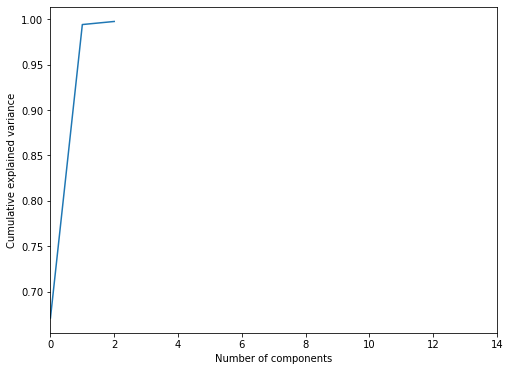

In [18]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

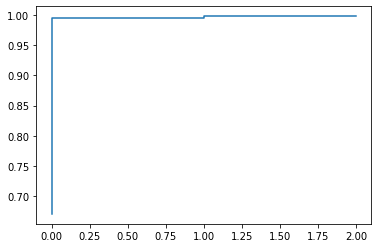

In [19]:
cumulative=np.cumsum(pca.explained_variance_ratio_)
plt.step([i for i in range(len(cumulative))],cumulative)
plt.show()

In [20]:
pca=PCA().fit(X_train)
print(pca.explained_variance_ratio_)
print()


[0.6712255  0.32282479 0.00338923 0.00256049 0.        ]



In [21]:
pipeline = Pipeline([
    ('pca', PCA(n_components=4)),
    ('nn', MLPRegressor(**grid_search.best_params_))
])

In [22]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [23]:
# Calculate Mean Squared Error (MSE) of the predictions 
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 87.35317391871638
R-squared: 0.5154911107390299
